In [16]:
from gpn.data import Genome
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
from scipy.stats import fisher_exact
from scipy.stats.contingency import odds_ratio
from sklearn.metrics import average_precision_score
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()

In [147]:
datasets = [
    #"de_novo_v3/5_prime_UTR_variant/9",
    #"de_novo_v3/3_prime_UTR_variant/9",
    #"de_novo_v3/upstream_gene_variant/9",
    #"de_novo_v3/non_coding_transcript_exon_variant/9",
    #"de_novo_v2",
    "de_novo_v4/9",
    #"de_novo_v4_all",
]

models = [
    "gpnmsa",
    "CADD_RawScore",
    #"phyloP-100v",
    #"phyloP-241m",
    #"phastCons-43p",
    "phyloP-100v_noimputation",
    "phyloP-241m_noimputation",
    "phastCons-43p_noimputation",
]

model_renaming = {
    "gpnmsa": "GPN-MSA",
    "CADD_RawScore": "CADD",
    "phyloP-100v_noimputation": "phyloP-100v",
    "phyloP-241m_noimputation": "phyloP-241m",
    "phastCons-43p_noimputation": "phastCons-43p",
}

def load_dataset(dataset):
    V = pl.read_parquet(f"../../results/dataset/{dataset}/test.parquet")
    for model in models:
        V = V.with_columns(
            pl.read_parquet(f"../../results/dataset/{dataset}/features/{model}.parquet")["score"].alias(model_renaming.get(model, model))
        )
    return V

V = pl.concat((load_dataset(dataset) for dataset in datasets))
models = [model_renaming.get(model, model) for model in models]
print(V.select(models).null_count())
V = V.drop_nulls(models)
V

shape: (1, 5)
┌─────────┬──────┬─────────────┬─────────────┬───────────────┐
│ GPN-MSA ┆ CADD ┆ phyloP-100v ┆ phyloP-241m ┆ phastCons-43p │
│ ---     ┆ ---  ┆ ---         ┆ ---         ┆ ---           │
│ u32     ┆ u32  ┆ u32         ┆ u32         ┆ u32           │
╞═════════╪══════╪═════════════╪═════════════╪═══════════════╡
│ 0       ┆ 0    ┆ 8           ┆ 4           ┆ 4             │
└─────────┴──────┴─────────────┴─────────────┴───────────────┘


chrom,consequence,pos,ref,alt,label,trait,AF,match_group,GPN-MSA,CADD,phyloP-100v,phyloP-241m,phastCons-43p
str,str,i64,str,str,bool,str,f64,i64,f32,f32,f64,f64,f64
"""1""","""upstream_gene_variant""",1448789,"""T""","""A""",false,null,0.0,116,1.28,0.129763,-1.292,0.11,0.034
"""1""","""5_prime_UTR_variant""",1471844,"""G""","""A""",false,null,0.0,204,1.11,0.657277,-0.557,-0.1,0.0
"""1""","""5_prime_UTR_variant""",2228478,"""G""","""A""",false,null,0.0,201,1.74,1.412812,0.215,0.13,0.735
"""1""","""5_prime_UTR_variant""",2476337,"""G""","""T""",false,null,0.0,199,-0.22,-0.114094,-3.137,-3.52,0.561
"""1""","""5_prime_UTR_variant""",3650030,"""G""","""A""",false,null,0.0,208,1.38,1.171913,0.33,-0.546,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""22""","""3_prime_UTR_variant""",38864827,"""C""","""T""",false,null,0.0,401,1.14,-0.007061,-0.602,-0.016,0.002
"""22""","""3_prime_UTR_variant""",39131928,"""G""","""A""",false,null,0.0,400,2.33,0.234098,-0.231,0.127,0.549
"""22""","""3_prime_UTR_variant""",45194868,"""A""","""C""",false,null,0.0,401,0.54,0.188425,-0.042,0.43,0.001


In [148]:
V["label"].mean()

0.10021171489061398

In [149]:
def odds_ratio_score(y_true, y_pred, threshold_q=0.05):
    df = pl.DataFrame({"label": y_true, "score": -y_pred})
    threshold = df.select(pl.col("score").quantile(threshold_q))["score"]
    # TODO: need to decide how to handle ties... they are certainly an issue with phastCons
    #if threshold_q == 0.05:
    #    print((df["score"] <= threshold).sum())
    group_counts = (
        df.group_by(["label", pl.col("score") <= threshold]).len()
        .sort(["label", "score"])["len"].to_numpy().reshape((2,2))
    )
    #if threshold_q == 0.05:
    #    print(group_counts)
    res = odds_ratio(group_counts, kind="sample")
    ci = res.confidence_interval(confidence_level=0.95)
    return res.statistic, ci.low, ci.high

In [150]:
or_pcts = [
    0.1,
    1,
    10,
]

or_pct_cols = [f"OR@{or_pct}" for or_pct in or_pcts]

res = []
for model in tqdm(models):
    y_true = V["label"]
    y_pred = V[model]
    res.append((
        model,
        average_precision_score(y_true, y_pred),
        *[odds_ratio_score(y_true, y_pred, or_pct / 100) for or_pct in or_pcts]
    ))
res = pd.DataFrame(res, columns=["model", "AUPRC"] + or_pct_cols)
res

100%|██████████| 5/5 [00:00<00:00, 17.52it/s]


,model,AUPRC,OR@0.1,OR@1,OR@10
0,GPN-MSA,0.487902,"(36.24644549763033, 4.041960709632535, 325.041...","(62.33762886597938, 26.18658159638974, 148.395...","(17.20323068707725, 13.599529263383138, 21.761..."
1,CADD,0.464267,"(6.009433962264151, 1.0013267478590135, 36.065...","(29.114503816793892, 14.599824216112216, 58.05...","(15.786886625704907, 12.492597571450387, 19.94..."
2,phyloP-100v,0.425150,"(36.24644549763033, 4.041960709632535, 325.041...","(51.87881013587955, 22.974040513725924, 117.15...","(14.092724567311457, 11.164060380234133, 17.78..."
3,phyloP-241m,0.450092,"(36.24644549763033, 4.041960709632535, 325.041...","(19.934177215189873, 10.668939976302193, 37.24...","(19.036763831052944, 15.027710365300246, 24.11..."
4,phastCons-43p,0.306434,"(7.938297872340425, 5.725112158653985, 11.0070...","(7.938297872340425, 5.725112158653985, 11.0070...","(7.691981132075472, 6.108099111405598, 9.68657..."


<Axes: xlabel='model', ylabel='AUPRC'>

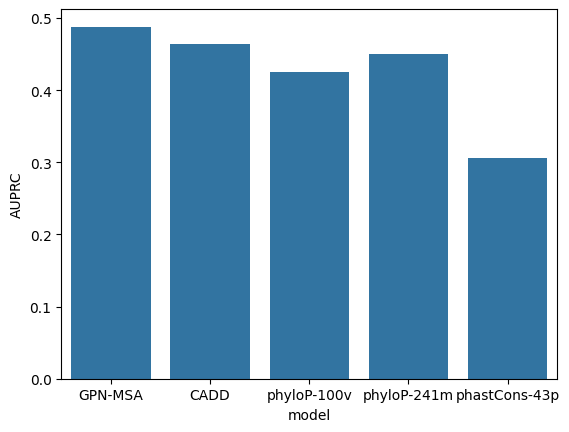

In [151]:
# TODO: should get AUPRC error bars
sns.barplot(data=res, x="model", y="AUPRC")

In [152]:
# Reshape the data from wide to long format for plotting using pandas.melt
res_long = res.melt(
    id_vars="model",
    value_vars=or_pct_cols,
    var_name="%",
    value_name="OR_CI",
)

# Extract OR and CI values into separate columns
# The .str accessor provides an efficient way to split tuples in a Series
res_long['OR'] = res_long['OR_CI'].str[0]
res_long['ci_low'] = res_long['OR_CI'].str[1]
res_long['ci_high'] = res_long['OR_CI'].str[2]
res_long

,model,%,OR_CI,OR,ci_low,ci_high
0,GPN-MSA,OR@0.1,"(36.24644549763033, 4.041960709632535, 325.041...",36.246445,4.041961,325.041460
1,CADD,OR@0.1,"(6.009433962264151, 1.0013267478590135, 36.065...",6.009434,1.001327,36.065447
2,phyloP-100v,OR@0.1,"(36.24644549763033, 4.041960709632535, 325.041...",36.246445,4.041961,325.041460
3,phyloP-241m,OR@0.1,"(36.24644549763033, 4.041960709632535, 325.041...",36.246445,4.041961,325.041460
4,phastCons-43p,OR@0.1,"(7.938297872340425, 5.725112158653985, 11.0070...",7.938298,5.725112,11.007046
5,GPN-MSA,OR@1,"(62.33762886597938, 26.18658159638974, 148.395...",62.337629,26.186582,148.395848
6,CADD,OR@1,"(29.114503816793892, 14.599824216112216, 58.05...",29.114504,14.599824,58.059215
7,phyloP-100v,OR@1,"(51.87881013587955, 22.974040513725924, 117.15...",51.878810,22.974041,117.150091
8,phyloP-241m,OR@1,"(19.934177215189873, 10.668939976302193, 37.24...",19.934177,10.668940,37.245633
9,phastCons-43p,OR@1,"(7.938297872340425, 5.725112158653985, 11.0070...",7.938298,5.725112,11.007046


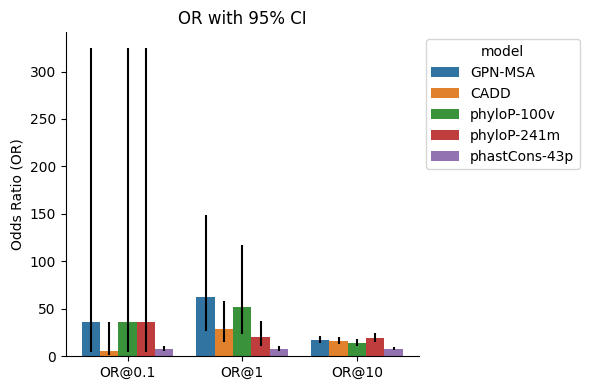

In [153]:
# 1. Create the bar plot
plt.figure(figsize=(6, 4))
ax = sns.barplot(data=res_long, x="%", y="OR", hue="model")

# 2. Add custom error bars robustly
for bar in ax.patches:
    # --- THIS IS THE FIX ---
    # Ignore invisible "ghost" patches that seaborn sometimes creates
    if bar.get_height() == 0 and bar.get_width() == 0:
        continue

    # Get the bar's color to identify its hue
    bar_color = bar.get_facecolor()

    # Get the x-tick label for the bar
    x_tick_index = int(round(bar.get_x() + bar.get_width() / 2))
    x_tick_label = ax.get_xticklabels()[x_tick_index].get_text()

    # Get the handles for the legend
    legend_handles, _ = ax.get_legend_handles_labels()

    hue_label = ""
    for handle in legend_handles:
        # Use the .patches[0] version for robustness across matplotlib versions
        if handle.get_facecolor() == bar_color:
            hue_label = handle.get_label()
            break

    # Find the corresponding data row in the DataFrame
    data_row = res_long[(res_long['model'] == hue_label) & (res_long['%'] == x_tick_label)]

    if data_row.empty:
        continue

    # Extract data from the correctly identified row
    ci_low = data_row['ci_low'].iloc[0]
    ci_high = data_row['ci_high'].iloc[0]

    # Use the bar's actual height for y-position and calculation
    bar_height = bar.get_height()

    # Calculate error bar magnitudes
    lower_error = bar_height - ci_low
    upper_error = ci_high - bar_height

    # Ensure errors are positive
    if lower_error < 0: lower_error = 0
    if upper_error < 0: upper_error = 0

    # Get the x-coordinate for the error bar
    x_coord = bar.get_x() + bar.get_width() / 2

    # Plot the correctly aligned error bar
    ax.errorbar(x=x_coord, y=bar_height, yerr=[[lower_error], [upper_error]],
                fmt='none',
                c='black')

# --- Final Touches ---
# Use ax.set_ylim() for setting y-axis limits
ax.set_ylim(bottom=0)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_title("OR with 95% CI")
ax.set_ylabel("Odds Ratio (OR)")
ax.set_xlabel("")
sns.despine()
plt.tight_layout()
plt.show()

In [113]:
plt.figure(figsize=(3, 3))
sns.histplot(
    data=V,
    x="GPN-MSA",
    hue="label",
    stat="density",
    common_norm=False,
    common_bins=True,
    bins=25,
)
sns.despine();

KeyboardInterrupt: 

<Figure size 300x300 with 0 Axes>

In [ ]:
plt.figure(figsize=(3, 3))
sns.histplot(
    data=V,
    x="CADD",
    hue="label",
    stat="density",
    common_norm=False,
    common_bins=True,
    bins=25,
)
sns.despine();

In [ ]:
plt.figure(figsize=(3, 3))
sns.histplot(
    data=V,
    x="phyloP-241m",
    hue="label",
    stat="density",
    common_norm=False,
    common_bins=True,
    bins=25,
)
sns.despine();